# Analysis 2-2: Preprocessing + bootstrap algorithm

In [1]:
spark

Intitializing Scala interpreter ...

Spark Web UI available at http://localhost:4040
SparkContext available as 'sc' (version = 2.3.2, master = local[*], app id = local-1558865537078)
SparkSession available as 'spark'


res0: org.apache.spark.sql.SparkSession = org.apache.spark.sql.SparkSession@32dc6701


In [2]:
//%load src/scala/spark_imports.scala

In [3]:
import org.apache.spark.sql._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._

import org.apache.spark.sql._
import org.apache.spark.sql.DataFrame
import org.apache.spark.sql.functions._
import org.apache.spark.sql.types._
import spark.implicits._


## Load the datasets into Spark
## This analysis is currently only implemented on the male group

In [4]:
val basedir = "spark-warehouse/experiment2-data/"

// prescription data for unhospitalized patients
spark.read.parquet(basedir+"male/unhosp_pres")
    .createOrReplaceTempView("e2_healthy_pres")

// prescription data hospitalized patients
spark.read.parquet(basedir+"male/hosp_pres")
    .createOrReplaceTempView("e2_hosp_pres")

// hospitalization data for elders 
spark.read.parquet(basedir+"male/hosp_npr")
    .createOrReplaceTempView("e2_hosp_npr")

// prescription duration estimates for all elders
spark.read
    .parquet("spark-warehouse/experiment2-data/elders_drug_duration/")
    .createOrReplaceTempView("e2_drug_duration")

basedir: String = spark-warehouse/experiment2-data/


## Get the intersection between Drugs in healthy and hospitalized patients

In [5]:

val drugs_in_unhosp = spark.sql("select * from e2_healthy_pres")
    .select("drugcode").distinct//.count
val drugs_in_hosp = spark.sql("select * from e2_hosp_pres")
    .select("drugcode").distinct//.count
// We may want to look at occurrence of each drug for the two populations
// However this will be kept in mind for later
println("# drugs in healthy population: ",drugs_in_unhosp.count)
println("# drugs in hosp population:",drugs_in_hosp.count)

//
def get_drug_intersection(a:DataFrame, b:DataFrame):DataFrame = {
    a.select($"drugcode".as("drugcode2"))
    .join(b, $"drugcode"===$"drugcode2").select("drugcode")
    .sort(asc("drugcode")).distinct
}

val drug_intersection = get_drug_intersection(drugs_in_unhosp, drugs_in_hosp)
drug_intersection.createOrReplaceTempView("e2_drugcodes")


(# drugs in healthy population: ,1039)
(# drugs in hosp population:,1040)


drugs_in_unhosp: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [drugcode: string]
drugs_in_hosp: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [drugcode: string]
get_drug_intersection: (a: org.apache.spark.sql.DataFrame, b: org.apache.spark.sql.DataFrame)org.apache.spark.sql.DataFrame
drug_intersection: org.apache.spark.sql.DataFrame = [drugcode: string]


In [6]:
/*
    Counts of drugs in each subpopulation ( can be commented out )
*/
println("Drugs in intersection : ", drug_intersection.count)

//println("hospitalized only")
val hosp_except_healthy = drugs_in_hosp
    .join(drugs_in_unhosp.select($"drugcode".as("drugcode2"))
          , $"drugcode"===$"drugcode2", "leftanti")
    .sort(asc("drugcode")).count//.show

//println("healthy only")
val healthy_except_hosp = drugs_in_unhosp
    .join(drugs_in_hosp.select($"drugcode".as("drugcode2"))
          , $"drugcode"===$"drugcode2", "leftanti")
    .sort(asc("drugcode")).count//.show


(Drugs in intersection : ,949)


hosp_except_healthy: Long = 91
healthy_except_hosp: Long = 90


In [7]:
//%load src/python/e2_imports.py
//add %%python as first line since we're in spylon kernel

In [8]:
%%python
import sklearn.preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import pandas as pd
from pyspark.sql.functions import collect_list, struct, col, explode, rand
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

## We create a drug encoder using the drugs from intersection
* We use sklearn's MultiLabelBinarizer
* Using all levels in the ATC system we get 938 drugs overlapping between the two populations, we will attempt to use all levels with the full population

In [9]:
%%python
drugs = np.array([d[0] for d in spark.sql("select * from e2_drugcodes") \
              .collect()]).reshape(-1)[None].T
print("drug-array shape:", drugs.shape)


def create_multilabelbinarizer_from_np_arr(elements):
    drugencoder = MultiLabelBinarizer()
    drugencoder.fit_transform(drugs)
    return drugencoder

drugencoder = create_multilabelbinarizer_from_np_arr(drugs)

transformed = drugencoder.transform(drugs[:3])
test_sample =  transformed[0:1]+transformed[1:2]+transformed[2:3]
inverse = drugencoder.inverse_transform(test_sample)

print("sample transformed:\n", transformed[:,:10])
print("sample inv-transformed (first 10 indices)", inverse)

drug-array shape: (949, 1)
sample transformed:
 [[1 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]]
sample inv-transformed (first 10 indices) [('A01AA01', 'A01AB03', 'A01AB04')]


### Create an ATC to description map using a helper function
* This allows us to go from ATC-code to drug name (chemical substance)

In [10]:
%%python
from src.python.csv_to_dict import csv_to_dict
atc_to_description = csv_to_dict("datasets/atc_to_descr/2014_atc.csv")

# Conversion of prescription data takes place in multiple stages
### We need a method to look up which drugs are currently in use from new dataset
1. We intersected the drugs in each patient group, and created an encoder which produces a vector given a set of drugs, or a matrix if given a sample with multiple sets of drugs:  [drug 1, drug 3] => [0, 1, 0, 1, 0...]
___
### Healthy patients 
1. Sample IDs with replacement from the set of IDs in healthy population
2. Take a random date in (0,365) for each sampled ID => DF("id") becomes DF("id", "randomdate".as("date")
3. Join with Drug Duration dataset on conditions: 
    
    * healthy[id]===drug_dur[id]
    
    * healthy[date] > drug_dur[treatment_start]
    
    * healthy[date] < drug_dur[treatment_end]

4. GroupBy (Id, date) and aggregate with collect_list. This returns a set of drugs per  patient-date selection
___

### Hospitalized patients
1. Convert hospitalizations to windows between hospitalizations
2. select the N longest windows
3. take a point in time X days prior to the hospitalization (10-30 days?)
4. Lookup all active drugs at point in time in active drugs dataset
___ 
### Now convert healthy patient's data to vector format by dividing their time series into 30-day windows
* This may have to be done in chunks if the data doesn't fit python's memory

### How do we preprocess healthy patients?
1. We need the healthy patients
2. Take all drug durations from healthy population joining drug duration set with healthy patients
3. Limit them between day 0 and day 365
#### To sample from the healthy patients we do the following
1. Sample a fraction of the patients from healthy_patients
2. 

In [ ]:
spark.sql("show tables").show()
val drug_durations = spark.sql("select * from e2_drug_duration").as("t1")
    .join(spark.sql("select distinct id from e2_healthy_pres").as("t2"), 
          $"t1.id" === $"t2.id")
    .select("t1.*")

val frac = 0.4
spark.sql("select distinct id from e2_healthy_pres")
    // False is without replacement, we want with
    .sample(false, frac)
    .select($"id".as("id2"), (rand()*365).as("timestamp").cast("int"))
    .join(drug_durations)
    .where(
        $"id" === $"id2"
        &&
        $"timestamp" >= $"treatment_start"
        &&
        $"timestamp" <= $"treatment_end"
          )
    .drop("id2")
    .groupBy("id")
    .agg(collect_list($"drugcode").as("active_drugs"))
//    .withColumn("len", size($"active_drugs"))
//    .sort(desc("len"))
    .show(10)

In [12]:
spark.sql("show tables").show
spark.sql("select * from e2_drug_duration").printSchema
spark.sql("select * from e2_hosp_pres").printSchema

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
|        |e2_drug_duration|       true|
|        |    e2_drugcodes|       true|
|        | e2_healthy_pres|       true|
|        |     e2_hosp_npr|       true|
|        |    e2_hosp_pres|       true|
+--------+----------------+-----------+

root
 |-- id: string (nullable = true)
 |-- drugcode: string (nullable = true)
 |-- treatment_start: integer (nullable = true)
 |-- treatment_end: integer (nullable = true)

root
 |-- id: string (nullable = true)
 |-- birthyear: integer (nullable = true)
 |-- drugcode: string (nullable = true)
 |-- diff_utleveringdato: integer (nullable = true)
 |-- gender: integer (nullable = true)



### Hospitalized patients
1. Convert hospitalizations to windows between hospitalizations
2. select the N longest windows
3. take a point in time X days prior to the hospitalization (10-30 days?)
4. Lookup all active drugs at point in time in active drugs dataset

In [13]:
%%python
#This function is refactored into the utility file: 
# src/python/npr_hospitalization_to_timestamp_prior_to_hosp.py
#We impose a limitation that the previous hospitalization must be more than "days_prior"
#days before the timestamp we collect
"""

def get_timestamp_from_n_longest_windows(hosp_list, n=1, days_prior=30):
    if True:
        print("DEPRECATED, import from src/python/npr_hospitalization_to_timestamp.py")
        return
    tstamps = []
    i=0
    #-270 is the hard limit for dates in the hospitalized dataset
    #pre_first_hosp_end is the timestamp of the first hospitalization of the patient
    #Thus we obtain min duration without hospitalization as ..
    # diff(-270, first_hospitalization)
    pre_first_hosp_start = -270
    pre_first_hosp_end = hosp_list[i][0]
    duration = pre_first_hosp_end-pre_first_hosp_start
    if duration > 2*days_prior:
        tstamps.append([pre_first_hosp_end-days_prior, duration])
        
    while i<(len(hosp_list) - 1):
        end = hosp_list[i+1][0]
        start = hosp_list[i][1]
        duration = end-start
        tstamp = end-days_prior
        tstamps.append([tstamp, duration])
        i+=1
    return list(
                map(lambda x:[x[0]],
                    filter(lambda x: x[1]>days_prior,
                           #Sort and take only the N longest windows per patient
                           sorted(tstamps, key=lambda x: x[1], reverse=True)[:n])
                   )
               )
"""

'\n\ndef get_timestamp_from_n_longest_windows(hosp_list, n=1, days_prior=30):\n    if True:\n        print("DEPRECATED, import from src/python/npr_hospitalization_to_timestamp.py")\n        return\n    tstamps = []\n    i=0\n    #-270 is the hard limit for dates in the hospitalized dataset\n    #pre_first_hosp_end is the timestamp of the first hospitalization of the patient\n    #Thus we obtain min duration without hospitalization as ..\n    # diff(-270, first_hospitalization)\n    pre_first_hosp_start = -270\n    pre_first_hosp_end = hosp_list[i][0]\n    duration = pre_first_hosp_end-pre_first_hosp_start\n    if duration > 2*days_prior:\n        tstamps.append([pre_first_hosp_end-days_prior, duration])\n        \n    while i<(len(hosp_list) - 1):\n        end = hosp_list[i+1][0]\n        start = hosp_list[i][1]\n        duration = end-start\n        tstamp = end-days_prior\n        tstamps.append([tstamp, duration])\n        i+=1\n    return list(\n                map(lambda x:[x[0]],

In [14]:
%%python
# Much of the functionality above and below is refactored into helper functions in the following package
from src.python.npr_hospitalization_to_timestamp_prior_to_hosp import get_timestamp_from_n_longest_windows

In [ ]:
%%python
from pyspark.sql.functions import collect_list, struct
#Fetch the list of hospitalizations
spark_hospitalization_list = spark.sql("""select * from e2_hosp_npr""")\
    .groupBy("id")\
    .agg(collect_list(struct("diffdager_inn", "diffdager_ut")))

# Get two fields: ID and hospitalization list created from aggregate above
col_labels = spark_hospitalization_list.schema.names
spark_hospitalization_list = spark_hospitalization_list\
    .select(col(col_labels[0]),col(col_labels[1]).alias("hospitalization_list"))

# Load the lists into pandas
singleListOfHospitalizations = spark_hospitalization_list.toPandas()

# Sort chronologically
lhosp = singleListOfHospitalizations
sorter = lambda l: sorted(l, key=lambda tup: tup[1])
lhosp[lhosp.columns[1]] = lhosp[lhosp.columns[1]].apply(sorter)
print("Sorted list of hospitalizations per patient: ")
print(lhosp[:10])

# From lists of hospitalizations per patient we now take up to 3 hospitalizations per patient

In [ ]:
%%time
%%python
from pyspark.sql.functions import explode

# Apply function to the list of hospitalization
# This should return a list of timestamps per-patient
windows = (lhosp[lhosp.columns[1]].map(
    lambda x: list(
        filter(
            lambda y: len(y)>0, 
            get_timestamp_from_n_longest_windows(x, n=3, days_prior = 30)
        )
    )
))

ids_with_windows = pd.DataFrame([lhosp[lhosp.columns[0]], windows]).T
#print(ids_with_windows[:3])

### We "explode" the list of hospitalizations, 
### basically a flatmap where each element
### in the list has its own (id, timestamp) row created
explodeDf  = spark.createDataFrame(ids_with_windows)


explodedDf2 = explodeDf.select("id",explode("hospitalization_list"))
explodedDf2.select(\
                   col("id"),\
                   col("col")[0].alias("timestamp")\
                  )\
.persist()\
.createOrReplaceTempView("e2_hosp_windows")

print(spark.sql("select * from e2_hosp_windows").count())
print(spark.sql("select distinct id from e2_hosp_windows").count())

In [18]:
%run src/scala/elders_lookup_active_drugs.scala

NOTE: scala/elders_lookup_active_drugs.scala is deprecated, use python/e2_drug_lookup.py or equivalent instead


## Create temp table of all unique healthy patients

In [19]:
%%python
spark.sql("select distinct id from e2_healthy_pres").createOrReplaceTempView("e2_healthy_pat")
spark.sql("show tables").show()

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
|        |e2_drug_duration|       true|
|        |    e2_drugcodes|       true|
|        |  e2_healthy_pat|       true|
|        | e2_healthy_pres|       true|
|        |     e2_hosp_npr|       true|
|        |    e2_hosp_pres|       true|
|        | e2_hosp_windows|       true|
+--------+----------------+-----------+



# Helper functions and imports for Classifier training
_____

In [20]:
%%python 
import mlflow
from src.python.e2_drug_lookup import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from src.python.helpers import plotfig_magic

In [21]:
%%python
def compute_roc(clf, Y_test, X_test):
    Y_score = clf.predict_proba(X_test)[:,1].reshape(-1)
    Y_truths = Y_test.reshape(-1)
    fpr, tpr, thresholds = roc_curve(Y_truths, Y_score, pos_label=1)
    return fpr, tpr


def log_classifier(clf):
    a = clf.coef_.T
    b = drugencoder.inverse_transform(np.ones((1,clf.coef_.shape[1])))[0]
    l = [t for t in zip(b,a)]
    for e in l:
        mlflow.log_param(e[0], e[1][0]) 

    
#log_classifier(clf)

In [22]:
spark.sql("show tables").show

+--------+----------------+-----------+
|database|       tableName|isTemporary|
+--------+----------------+-----------+
|        |e2_drug_duration|       true|
|        |    e2_drugcodes|       true|
|        |  e2_healthy_pat|       true|
|        | e2_healthy_pres|       true|
|        |     e2_hosp_npr|       true|
|        |    e2_hosp_pres|       true|
|        | e2_hosp_windows|       true|
+--------+----------------+-----------+



In [23]:
%%time
%%python
def experiment2_generate_dataset( frac_hosp=0.8, frac_healthy=0.8):
    # generate a random sample from the datasets
    sample_hosp_df, sample_healthy_df = sample_and_get_drugs_from_both(
        spark.sql("select * from e2_hosp_windows")
        ,spark.sql("select * from e2_healthy_pat")
        ,spark.sql("select * from e2_drug_duration")
        ,frac_hosp
        ,frac_healthy
    )

    sample_hosp = sample_hosp_df.collect()
    hosp_encoded = drugencoder.transform([d["active_drugs"] for d in sample_hosp])

    sample_healthy = sample_healthy_df.collect()
    healthy_encoded =  drugencoder.transform([d["active_drugs"] for d in sample_healthy])

    healthy_X, healthy_Y = healthy_encoded, np.zeros((healthy_encoded.shape[0], 1))
    hosp_X, hosp_Y = hosp_encoded, np.ones((hosp_encoded.shape[0], 1) )
    
    #Stack training vectors and labels
    e2_dset_X = np.vstack((healthy_X, hosp_X ))
    e2_dset_Y = np.vstack((healthy_Y, hosp_Y))

    X_train, X_test, Y_train, Y_test =\
        train_test_split(e2_dset_X, e2_dset_Y, test_size=0.33)
   
    return X_train, X_test, Y_train, Y_test
if True:
    experiment2_generate_dataset()

2019-05-26 12:12:51 WARN  TaskSetManager:66 - Stage 56 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
Time: 9.294887781143188 seconds.



In [24]:
%%python

def bootstrap_iteration(dataset, C=1e40, solver="liblinear"):
    X_train, X_test, Y_train, Y_test = dataset
    clf = LogisticRegression(C=C, solver=solver, n_jobs=4, penalty="l2")
    clf.fit(X_train, Y_train)
    
    metrics = {}
    metrics["train_accuracy"] = clf.score(X_train,Y_train)
    metrics["train_confusion"] = confusion_matrix(Y_train, clf.predict(X_train))
    metrics["test_accuracy"] = clf.score(X_test,Y_test)
    metrics["test_confusion"] = confusion_matrix(Y_test, clf.predict(X_test))
    metrics["model_coefficients"] = clf.coef_
    metrics["model_intercept"] = clf.intercept_
    metrics["data_train_shape"] = X_train.shape
    metrics["data_test_shape"] = X_test.shape
    return clf, X_test, Y_test, metrics

In [25]:
%%python
#Test dataset generation
sample = experiment2_generate_dataset(frac_hosp=0.99, frac_healthy=0.99)


2019-05-26 12:13:00 WARN  TaskSetManager:66 - Stage 62 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.


In [26]:
%%python
print([e.shape for e in sample])
# Compute sparsity of the training matrix
trainingset = sample[0]
total_variables = trainingset.shape[0]*trainingset.shape[1]
total_active_drugs = trainingset.sum()
print("training observations")
print(trainingset.shape[0])
print("total indices in training set")
print(total_variables)
print("total number of drugs prescribed")
print(total_active_drugs)


density = total_active_drugs/total_variables
sparsity = 1.0-density
print("Sparsity = {0}".format(sparsity))
print("Mean prescriptions per observation = {0}".format(density*trainingset.shape[1]))


traininglabels = sample[2]
n_hosp = traininglabels.sum()
print("Hospitalized percentage of data = %.2f" % (100*n_hosp/trainingset.shape[0]) + "%")

max_n_active_treatments = np.max(trainingset.sum(axis=1))
print(max_n_active_treatments)
n_treatment_distribution  =  list(map((lambda i : np.sum(trainingset.sum(axis=1) == i)), range(0,max_n_active_treatments+1)))
print(n_treatment_distribution)


[(210300, 949), (103582, 949), (210300, 1), (103582, 1)]
training observations
210300
total indices in training set
199574700
total number of drugs prescribed
833395
Sparsity = 0.995824145044437
Mean prescriptions per observation = 3.9628863528292917
Hospitalized percentage of data = 37.67%
28
[516, 35505, 36433, 34703, 30056, 23466, 16941, 11837, 7827, 5079, 3182, 1913, 1229, 737, 388, 208, 140, 66, 33, 18, 11, 6, 3, 1, 1, 0, 0, 0, 1]


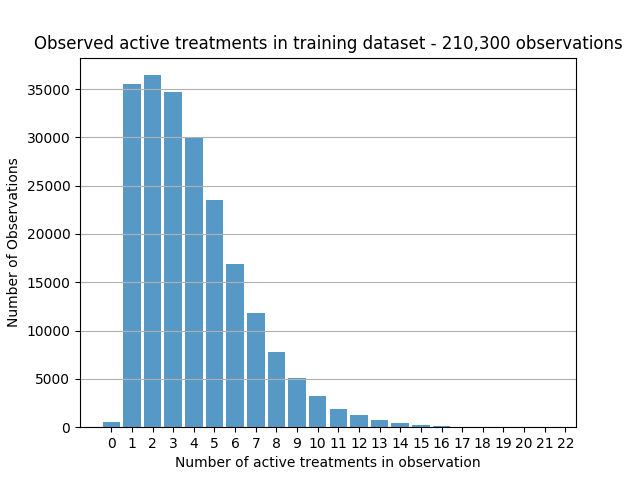

In [27]:
%%python
plt.clf()
left_of_first_bin = -0.5
bins = max_n_active_treatments-6
right_of_last_bin = bins + 0.5
plt.hist( trainingset.sum(axis=1), np.arange(left_of_first_bin,right_of_last_bin, 1),
         alpha=0.75, rwidth=0.85
        )
plt.grid(axis="y")
#plt.grid(axis="x")
plt.xticks( np.arange(0, bins+1) )
plt.xlabel("Number of active treatments in observation")
plt.ylabel("Number of Observations")
plt.title(
    "Observed active treatments in training dataset - {:,} observations".format(
        int(trainingset.shape[0])
        )
    )
retval = plotfig_magic()


# Setup variables for experiment

In [28]:
%%python
import time
import datetime
import os

metrics_savedir = "spark-warehouse/numpy/e2/runs/FINAL/"
bootstrap_samples = 2000

if not os.path.exists(metrics_savedir):
    try:
        os.mkdir(metrics_savedir)
        print("made directory:", metrics_savedir)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise


In [29]:
%%python
X_train, X_test, Y_train, Y_test = sample
X_train.shape

# Run the bootstrap logistic regressions
* The metrics and models are stored at the metrics_savedir path
## Note: Output is omitted because it contained 2000 lines of status messages.

In [ ]:
%%python

start_time = datetime.datetime.now()
np.save(metrics_savedir+"encoder", drugencoder)

i=0
est_single_iter = None
with open(metrics_savedir+"runs.csv", "w") as f:
        f.writelines(
            ["run;runtime;\n"]
        )
while i<bootstrap_samples:      
    print("run {0} of {1}".format(i+1, bootstrap_samples))
    iter_start_time = datetime.datetime.now()
    sample = experiment2_generate_dataset(frac_hosp=0.99, frac_healthy=0.99)
    clf, X_test, Y_test, metrics = bootstrap_iteration(sample)

    fpr, tpr = compute_roc(clf, Y_test, X_test)
    metrics["concordance"] = {}
    metrics["concordance"]["fpr"]=fpr 
    metrics["concordance"]["tpr"]=tpr
    np.save(metrics_savedir+str(i), metrics)
    
    #Write status of run (Notebook may be closed if the code is run in tmux)
    with open(metrics_savedir+"_BootstrapStatus.txt", "w") as f:
        curr_time = datetime.datetime.now()
        f.writelines(
            [
                "Start_time:"+str(start_time)+"\n",
                "Current_time:"+str(curr_time)+"\n",
                "Total_runtime:"+str(curr_time-start_time)+"\n",
                "Current_run: "+str(i)+"\n",
                "Current_run_runtime_seconds:"+str(curr_time.timestamp()-iter_start_time.timestamp()),
                "Target_runs:"+str(bootstrap_samples)+"\n"
            ]
        )
        if est_single_iter == None:
            est_single_iter = curr_time-start_time
        est_eta = est_single_iter*(bootstrap_samples-i)
        f.write("ETA:"+str(est_eta)+"\n")
        f.write("EET:"+str(curr_time+est_eta)+"\n")
        
    with open(metrics_savedir+"runs.csv", "a") as f:
        f.writelines(
            ["{0};{1:.2f}\n".format(i, curr_time.timestamp()-iter_start_time.timestamp())]
        )
    i+=1


end = time.time()
with open(metrics_savedir+"_BootstrapSuccess.txt", "w") as f:
        end_time = datetime.datetime.now()
        f.writelines(
            [
                "Start_time:"+str(start_time)+"\n",
                "End_time:"+str(end_time)+"\n",
                "Total_runtime:"+str(end_time-start_time)+"\n",
                "Current_run: "+str(i)+"\n",
                "Target_runs:"+str(bootstrap_samples)+"\n"
            ]
        )
print("finished in..")
print(end_time-start_time)

In [31]:
%%python
sample = experiment2_generate_dataset(frac_hosp=0.99, frac_healthy=0.99)
X_train, X_test, Y_train, Y_test = sample
print("Total samples")
print(Y_test.shape[0])
print("Hospitalized samples")
print(Y_test.sum())
print("Unhospitalized samples")
print(Y_test.shape[0]-Y_test.sum())
print("----")

2019-05-27 03:19:57 WARN  TaskSetManager:66 - Stage 12068 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
Total samples
103600
Hospitalized samples
39209.0
Unhospitalized samples
64391.0
----


# Bootstrap sampling time

In [40]:
%%time
%%python
dataset = experiment2_generate_dataset( frac_hosp = 0.99, frac_healthy = 0.99)

2019-05-27 16:15:52 WARN  TaskSetManager:66 - Stage 12099 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
Time: 8.998230457305908 seconds.



# Logistic regression training time

In [44]:
%%time
%%python
def time_logreg(dataset, C=1e40, solver="liblinear"):
    X_train, X_test, Y_train, Y_test = dataset
    clf = LogisticRegression(C=C, solver=solver, n_jobs=4, penalty="l2")
    clf.fit(X_train, Y_train)
time_logreg(dataset)


Time: 19.695088624954224 seconds.



# Total time

In [32]:
%%time
%%python
dataset = experiment2_generate_dataset( frac_hosp = 0.99, frac_healthy = 0.99)
clf, X_test, Y_test, metrics = bootstrap_iteration(dataset)

2019-05-27 03:20:05 WARN  TaskSetManager:66 - Stage 12074 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
Time: 29.625468015670776 seconds.



0.7307726800961463


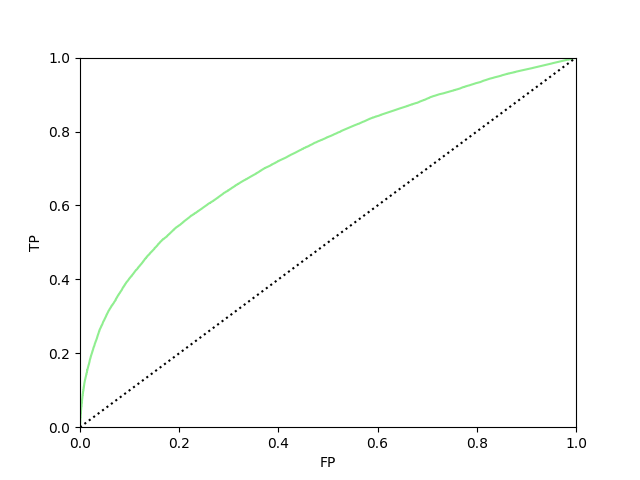

In [45]:
%%python
fpr, tpr = compute_roc(clf, Y_test, X_test)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.clf()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, color="lightgreen")
plt.plot([0,1],[0,1], linestyle=":", color="black")
plt.xlabel("FP")
plt.ylabel("TP")
retval = plotfig_magic()

In [34]:
%%time
%%python
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

X_train, X_test, Y_train, Y_test = experiment2_generate_dataset()



clf = LogisticRegression(C=1e7)
clf.fit(X_train, Y_train)

print("In-sample mean training accuracy")
print(clf.score(X_train,Y_train))
print("Confusion matrix")
print(confusion_matrix(Y_train, clf.predict(X_train)))
print("Test set mean training accuracy")
print(clf.score(X_test,Y_test))
print("Confusion matrix")
print(confusion_matrix(Y_test, clf.predict(X_test)))


#model_params.append(clf.coef_)
#model_intercepts.append(clf.intercept_)



2019-05-27 03:20:35 WARN  TaskSetManager:66 - Stage 12080 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
In-sample mean training accuracy
0.7071096710041317
Confusion matrix
[[93379 12206]
 [39046 30356]]
Test set mean training accuracy
0.7043590249335762
Confusion matrix
[[45621  6160]
 [19321 15087]]
Time: 22.119540452957153 seconds.



In [35]:
%%python
print(clf.predict_proba(X_test[1303:1310]))
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))
print(sigmoid(np.multiply(clf.coef_,X_test[1303:1304]).sum()+clf.intercept_))

[[0.7944149  0.2055851 ]
 [0.73902961 0.26097039]
 [0.77396895 0.22603105]
 [0.7122187  0.2877813 ]
 [0.79794542 0.20205458]
 [0.81329486 0.18670514]
 [0.73705469 0.26294531]]
[0.2055851]


### Example of repeated random number draws

In [ ]:
val tdf = spark.range(100).toDF
val selection = tdf.select($"id", (rand()*365))
selection
    .unionAll(tdf.select($"id", (rand()*365)))
    .unionAll(tdf.select($"id", (rand()*365)))
    .sort(asc("id")).show

# ROC / AUC of 1 bootstrap logistic regression model

2019-05-27 03:20:58 WARN  TaskSetManager:66 - Stage 12087 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
0.7326584018997117


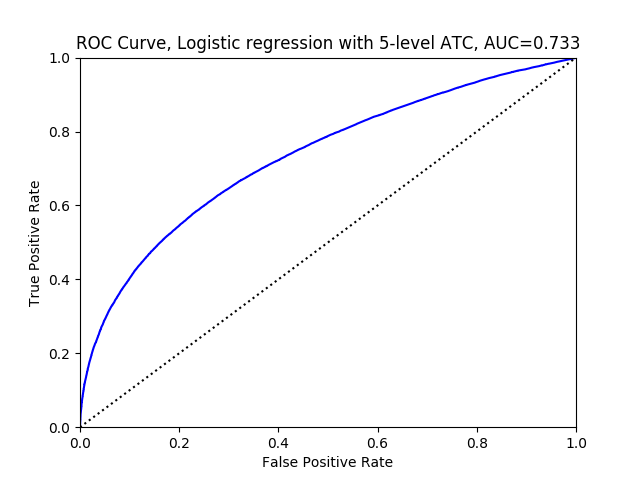

In [37]:
%%python
sample = experiment2_generate_dataset(frac_hosp=0.99, frac_healthy=0.99)
#print(sample)
clf, X_test, Y_test, metrics = bootstrap_iteration(sample)
fpr, tpr = compute_roc(clf, Y_test, X_test)
roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.clf()
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.plot(fpr, tpr, color="blue")
plt.plot([0,1],[0,1], linestyle=":", color="black")
plt.title("ROC Curve, Logistic regression with 5-level ATC, AUC={0:.3f}".format(roc_auc))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig("plots/ml_alg2_auc.pdf")
retval = plotfig_magic()

In [38]:
%%python
print([s.shape for s in sample])
print(sample[2].sum()/sample[2].shape[0])
print(sample[3].sum()/sample[3].shape[0])

[(210356, 949), (103609, 949), (210356, 1), (103609, 1)]
0.3775837152256175
0.3787508807149958


# Time taken for 1 bootstrap iteration with sampling

In [39]:
%%time
%%python
sample = experiment2_generate_dataset(frac_hosp=0.99, frac_healthy=0.99)
clf, X_test, Y_test, metrics = bootstrap_iteration(sample)

fpr, tpr = compute_roc(clf, Y_test, X_test)

2019-05-27 03:21:19 WARN  TaskSetManager:66 - Stage 12093 contains a task of very large size (525 KB). The maximum recommended task size is 100 KB.
Time: 28.083719968795776 seconds.

